Туториал вольно основан на туториале для tensorflow:
https://www.tensorflow.org/tutorials/text/image_captioning

В данном ноутбуке, мы будем генерировать текстовые описания к изображению, используя:
- Предобученный кодировщик изображений (Сеть Inception-v3)
- Рекурретный декодер (генератор текста)
- Механизм внимания, позволяющий декодеру считывать данные с закодированного изображения, в процессе генерации текста.

In [1]:
# !pip install pytorch-lightning

In [2]:
import tensorflow as tf
import os

In [3]:
COCO_ROOT_PATH = '.'

In [4]:
# Download caption annotation files
annotation_folder = 'annotations/'
if not os.path.exists(annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
    annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
    os.remove(annotation_zip)

# Download image files
image_folder = 'train2014/'
if not os.path.exists(image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
    os.remove(image_zip)


In [5]:
import os
import json
from itertools import islice
from PIL import Image
from collections import OrderedDict

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

### Загрузка данных
Сопоставим текстовые описания с путями к изображению. <br>
Одному изображению может соответствовать несколько описаний. <br>
Делить на выборки будем по изображению, таким образом одно изображение и все его описания гарантированно окажутся в одной выборке

In [7]:
IMAGES_PATH = os.path.join(COCO_ROOT_PATH, 'train2014')

In [8]:
CAPTIONS_PATH = os.path.join(COCO_ROOT_PATH, 
                             'annotations',
                             'captions_train2014.json')

In [9]:
with open(CAPTIONS_PATH) as f:
    image_metadata = json.load(f)

In [10]:
image_metadata.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [11]:
print(image_metadata['images'][:3])

[{'license': 5, 'file_name': 'COCO_train2014_000000057870.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-14 16:28:13', 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg', 'id': 57870}, {'license': 5, 'file_name': 'COCO_train2014_000000384029.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg', 'height': 429, 'width': 640, 'date_captured': '2013-11-14 16:29:45', 'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg', 'id': 384029}, {'license': 1, 'file_name': 'COCO_train2014_000000222016.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000222016.jpg', 'height': 640, 'width': 480, 'date_captured': '2013-11-14 16:37:59', 'flickr_url': 'http://farm2.staticflickr.com/1431/1118526611_09172475e5_z.jpg', 'id': 222016}]


In [12]:
print(image_metadata['annotations'][:3])

[{'image_id': 318556, 'id': 48, 'caption': 'A very clean and well decorated empty bathroom'}, {'image_id': 116100, 'id': 67, 'caption': 'A panoramic view of a kitchen and all of its appliances.'}, {'image_id': 318556, 'id': 126, 'caption': 'A blue and white bathroom with butterfly themed wall tiles.'}]


In [13]:
len(image_metadata['annotations'])

414113

In [14]:
image_id_to_path = {}
for image_meta in image_metadata['images']:
    image_id_to_path[image_meta['id']] = image_meta['file_name']

In [15]:
len(image_id_to_path)

82783

In [16]:
next(iter(image_id_to_path.items()))

(57870, 'COCO_train2014_000000057870.jpg')

In [17]:
all_image_paths = list(image_id_to_path.values())

In [18]:
len(all_image_paths)

82783

In [19]:
val_images=5000
test_images=10000

In [20]:
image_paths = {}

In [21]:
np.random.seed(13331)

In [22]:
image_paths['train'], test_val_image_paths = train_test_split(all_image_paths,
                                                           test_size=val_images + test_images)

In [23]:
image_paths['test'], image_paths['val'] = train_test_split(test_val_image_paths,
                                                           test_size=val_images)

In [24]:
len(image_paths['val'])

5000

In [25]:
image_path_to_subset = {}
for subset, paths in image_paths.items():
    for path in paths:
        image_path_to_subset[path] = subset

In [26]:
len(image_path_to_subset)

82783

In [27]:
next(iter(image_path_to_subset.items()))

('COCO_train2014_000000251803.jpg', 'train')

In [28]:
image_path_to_captions = {s:[] for s in ['train', 'val', 'test']}

for caption_doc in image_metadata['annotations']:
    image_id = caption_doc['image_id']
    image_path = image_id_to_path[image_id]
    image_subset = image_path_to_subset[image_path]
    
    image_path_to_captions[image_subset].append((image_path, caption_doc['caption']))

In [29]:
image_path_to_captions['train'][:3]

[('COCO_train2014_000000379340.jpg',
  'A graffiti-ed stop sign across the street from a red car '),
 ('COCO_train2014_000000379340.jpg',
  'A vandalized stop sign and a red beetle on the road'),
 ('COCO_train2014_000000134754.jpg',
  'The two people are walking down the beach.')]

# Предобученная модель классификации изображений

Загрузим претренированную модель Inception V3, полагаясь на https://pytorch.org/hub/pytorch_vision_inception_v3/

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

In [31]:
inception_preprocessing = preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Просмотрим, что препроцессинг делает

In [32]:
random_image_path, random_image_caption = image_path_to_captions['train'][3]

In [33]:
print(random_image_caption)

A sink and a toilet inside a small bathroom.


In [34]:
random_image = Image.open(os.path.join(IMAGES_PATH, random_image_path))

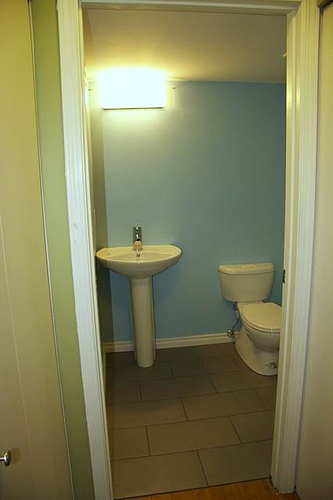

In [35]:
random_image

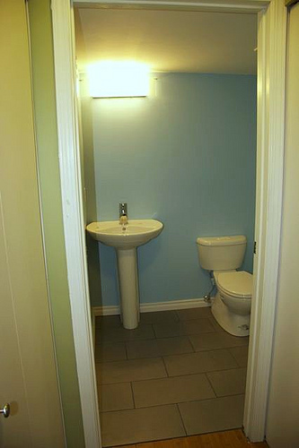

In [36]:
inception_preprocessing.transforms[0](random_image)

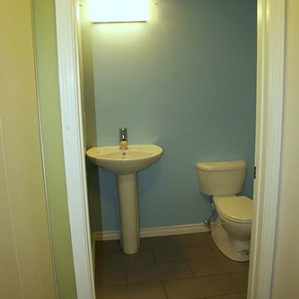

In [37]:
inception_preprocessing.transforms[1](
    inception_preprocessing.transforms[0](random_image))

Как видим, изображения становятся квадратными засчёт снижения размерности и вырезки из центра

Загрузим модель, предварительно проверив версию torchvision

In [38]:
import torchvision

In [39]:
torchvision.__version__

'0.8.2+cu110'

In [40]:
inception_model = torch.hub.load('pytorch/vision:v0.8.2', 'inception_v3', pretrained=True)

Using cache found in /home/ivan/.cache/torch/hub/pytorch_vision_v0.8.2


In [41]:
print(inception_model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Прогоним модель по изображению

In [42]:
transformed_image = inception_preprocessing(random_image)

In [43]:
transformed_image.size()

torch.Size([3, 299, 299])

Добавим ещё одно измерении в начале (батч)

In [44]:
transformed_image = transformed_image.unsqueeze(0)

In [45]:
transformed_image.size()

torch.Size([1, 3, 299, 299])

In [46]:
inception_model.eval()
pass

In [47]:
with torch.no_grad():
    output = inception_model(transformed_image)

Модель предсказала логиты (1, 1000) (1000 классов ImageNet).
Преобразуем их в вероятности

In [48]:
output.size()

torch.Size([1, 1000])

In [49]:
probs = F.softmax(output[0],dim=0)

In [50]:
# !https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

Считаем классы imagenet

In [51]:
with open("imagenet_classes.txt", "r") as f:
    imagenet_categories = [s.strip() for s in f.readlines()]

In [52]:
print(probs[:4])

tensor([6.1646e-06, 2.4429e-05, 2.9114e-05, 4.4131e-05])


In [53]:
sorted_classes = (-probs).argsort().tolist()

In [54]:
for sc in sorted_classes[:15]:
    print(imagenet_categories[sc], probs[sc].item())

washbasin 0.8093715906143188
plunger 0.04923097789287567
toilet seat 0.04032799229025841
shower curtain 0.031194783747196198
medicine chest 0.020159343257546425
bathtub 0.009142331779003143
toilet tissue 0.0067255254834890366
tub 0.003353932872414589
soap dispenser 0.0021572436671704054
prison 0.0018301480449736118
bath towel 0.0011380957439541817
table lamp 0.0010190350003540516
pedestal 0.0005737557075917721
hand blower 0.0005176394479349256
swab 0.00046137141180224717


Классификация работает, но есть проблема:

В данной реализации нет прямого способа получить представление перед пулингом

Погуглив, нашёл способ через register_forward_hook
Это способ задать функцию вызываемую после вызова forward в модуле. 
Обычно это функции для дебага

Но здесь, при помощи замыкания, будем сэйвить выход слоя в объекте

In [55]:
class HookStorage():
    def __init__(self):
        self.output = None
        
    def call_hook(self, module, inp, output):
        self.output = output

In [56]:
hook_storage = HookStorage()
hook = inception_model.Mixed_7c.register_forward_hook(hook_storage.call_hook)

In [57]:
with torch.no_grad():
    output = inception_model(transformed_image)

In [58]:
print(hook_storage.output.size())

torch.Size([1, 2048, 8, 8])


Мы не будет дотренировывать Inception, поэтому мы можем заранее вычислить промежуточные представления

Но сначала не помешает прикинуть их размер

In [59]:
len(image_paths['train'])

67783

In [60]:
len(image_path_to_captions['train'])

339074

In [61]:
(2048 * 8 * 8 * 4 * 80_000) / (1024 ** 3)

39.0625

Не, многовато, мб имеет смысл гонять через сеть напрямую

В любом случае, надо ещё разобраться с текстом.

Сделаем словарь, как для IMDB, но внесём доп. модификацию:
- Теперь каждый текст будет начинаться с токена \<START\> и заканчиваться токенов \<END\>. Генератор будет обучаться предсказывать токен \<END\> в конце текста, а также токен \<START\> сообщает ему, что мы в начале текста

In [62]:
from typing import List
from tqdm.notebook import tqdm
import nltk
import itertools
from collections import Counter

In [63]:
class Vocab:
    def __init__(self, itos: List[str], unk_index: int):
        self._itos = itos 
        # строим обратный индекс - слово - номер
        self._stoi = {word:i for i, word in enumerate(itos)}
        self._unk_index = unk_index
        
    def __len__(self):
        return len(self._itos)
    
    def word2id(self, word):
        idx = self._stoi.get(word)
        if idx is not None:
            return idx
        return self._unk_index
    
    def id2word(self, idx):
        return self._itos[idx]

In [64]:
class TextToIdsTransformer:
    def transform():
        raise NotImplementedError()
        
    def fit_transform():
        raise NotImplementedError()

In [65]:
class SimpleTextTransformer(TextToIdsTransformer):
    def __init__(self, max_vocab_size):
        self.special_words = ['<PAD>', '</UNK>', '<START>', '<END>']
        self.end_index = 3
        self.start_index = 2
        self.unk_index = 1
        self.pad_index = 0
        self.vocab = None
        self.max_vocab_size = max_vocab_size # 
        self._tokenizer = nltk.tokenize.TweetTokenizer()
        
    def tokenize(self, text):
        tokens = self._tokenizer.tokenize(text.lower())

        return tokens
        
    def build_vocab(self, tokens):
        itos = []
        itos.extend(self.special_words)
        
        # в словаре будут max_vocab_size - 4 самых частых слов
        token_counts = Counter(tokens)
        for word, _ in token_counts.most_common(self.max_vocab_size - len(self.special_words)):
            itos.append(word)
            
        self.vocab = Vocab(itos, self.unk_index)
    
    def tokens2ids(self, tokens: List[str]):
        return [self.start_index] + [self.vocab.word2id(token) for token in tokens] + [self.end_index]
    
    def ids2tokens(self, ids: List[int]):
        return [self.vocab.id2word(x) for x in ids]
        
    def transform_single_text(self, text):
        tokens =  self.tokenize(text)
        ids = self.tokens2ids(tokens)
        return ids
        
    def transform(self, texts):
        result = []
        for text in tqdm(texts):
            result.append(self.transform_single_text(text))
        return result
    
    def fit_transform(self, texts):
        result = []
        tokenized_texts = [self.tokenize(text) for text in tqdm(texts)]
        self.build_vocab(itertools.chain.from_iterable(tokenized_texts))
        for tokens in tqdm(tokenized_texts):
            tokens = tokens
            ids = self.tokens2ids(tokens)
            result.append(ids)
        return result

In [66]:
max_vocab_size = 5000

In [67]:
text_tokenizer = SimpleTextTransformer(max_vocab_size)

In [68]:
image_path_to_captions['train'][:3]

[('COCO_train2014_000000379340.jpg',
  'A graffiti-ed stop sign across the street from a red car '),
 ('COCO_train2014_000000379340.jpg',
  'A vandalized stop sign and a red beetle on the road'),
 ('COCO_train2014_000000134754.jpg',
  'The two people are walking down the beach.')]

In [69]:
encoded_captions = {}

In [70]:
encoded_captions['train'] = text_tokenizer.fit_transform(cap for path, cap in image_path_to_captions['train'])

|          | 0/? [00:00<?, ?it/s]

  0%|          | 0/339074 [00:00<?, ?it/s]

In [71]:
encoded_captions['val'] = text_tokenizer.transform(cap for path, cap in image_path_to_captions['val'])

|          | 0/? [00:00<?, ?it/s]

In [72]:
text_tokenizer.vocab._itos[:10]

['<PAD>', '</UNK>', '<START>', '<END>', 'a', '.', 'on', 'of', 'the', 'in']

In [73]:
encoded_captions['train'][:2]

[[2, 4, 1, 147, 61, 247, 8, 27, 99, 4, 50, 130, 3],
 [2, 4, 2592, 147, 61, 11, 4, 50, 1, 6, 8, 87, 3]]

In [74]:
from torch.utils.data import Dataset, DataLoader

In [75]:
paths_and_text_ids = {'train': [], 'val':[]}

Сопоставим пути к изображениям и закодированные тексты

In [76]:
for subset in ('train', 'val'):
    for i, (img_path, caption) in enumerate(image_path_to_captions[subset]):
        paths_and_text_ids[subset].append((img_path, encoded_captions[subset][i]))
        

In [77]:
paths_and_text_ids['train'][:4]

[('COCO_train2014_000000379340.jpg',
  [2, 4, 1, 147, 61, 247, 8, 27, 99, 4, 50, 130, 3]),
 ('COCO_train2014_000000379340.jpg',
  [2, 4, 2592, 147, 61, 11, 4, 50, 1, 6, 8, 87, 3]),
 ('COCO_train2014_000000134754.jpg', [2, 8, 17, 21, 22, 58, 34, 8, 78, 5, 3]),
 ('COCO_train2014_000000538480.jpg',
  [2, 4, 119, 11, 4, 85, 161, 4, 39, 60, 5, 3])]

In [78]:
from torch.nn.utils.rnn import pad_sequence

Датасет для получения батчей из изображений и соответствующих им текстов

При обращение за строкой по номеру, объект загружает изображение с диска и преобразует его для Inception в тензорный формат (H,W,3) и текст в виде тензора длиной n_words.

В функции collate мы получаем батч из списка строк датасета.

Для изображений, поскольку у них одинаковые размеры (299,299,3) нам достаточно сложить тензоры в стопку (стекинг) вдоль нового измерения -> (batch_size, 299,299,3)

Для текстов нужно выровнять тензоры по длине. Для этого мы используем pad_sequences

Итого, имеем тензор размером (batch_size, max_text_len(batch))

In [79]:
class InceptionCaptionDataset(Dataset):
    def __init__(self, paths_and_caption_ids, image_transform):
        self.paths_and_caption_ids = paths_and_caption_ids
        self.image_transform = image_transform
        
    def __getitem__(self, idx):
        path, text_ids = self.paths_and_caption_ids[idx]
        full_path = os.path.join(IMAGES_PATH, path)
        im = Image.open(full_path)
        rgb_im = im.convert('RGB')

        final_img = self.image_transform(rgb_im)
        
        final_text = torch.tensor(text_ids, dtype=torch.long)
        return (final_img, final_text)
    
    def __len__(self):
        return len(self.paths_and_caption_ids)
    
    @staticmethod
    def collate(dataset_rows):
        image_tensor = torch.stack([img_tensor for img_tensor,_ in dataset_rows])
        text_tensors = [text_ids for _, text_ids in dataset_rows]
        text_tensor = pad_sequence(text_tensors, batch_first=True, padding_value=0)
        return image_tensor, text_tensor

In [80]:
# ds_example = InceptionCaptionDataset(paths_and_text_ids['val'], inception_preprocessing)

In [81]:
# print(ds_example[4])

In [82]:
# print(ds_example.collate([ds_example[i] for i in range(4)]))

In [83]:
# del ds_example

Теперь, попробуем построить сеть для решения задачи.

Для этого нам нужны:
- Кодировщик изображений
- Генератор текста (decoder), который должен как-то учитывать закодированное изображение

В качестве кодировщика мы будем использовать уже готовую модель для классификации (Inception-V3)
В качестве декодировщика мы будем использовать рекуррентную сеть.
Чтобы декодировщик знал об изображении, на каждом шаге генерации будет вычислять "вектор наложения" (alignment vector), который вычисляется путём сопоставления изображения на последнем слое Inception-сети и текущего состояния генератора.

Таким образом, мы будем использовать механизм внимания.

Представление на последнем слое `Inception` перед пулингом имеет размерность (2048 8,8), что т.е. это 64 вектора размерностью 2048. Для упрощения будем считать что у нас тензор (64, 2048)

Для уменьшения числа вычислений и по другим причинам, мы применим линейное преобразование к каждому вектору, чтобы уменьшить его размерность до величины `image_embedding_dim`. В результате имеем матрицу `img_features` размером (64, image_embedding_dim)

Состояние рекуррентной сети `state_t` на шаге t имеет размерность `rnn_state_dim`.

Временно проигнорируем batch-измерение. 
Тогда слой должен вычислить вектор `context_vector` размерностью `image_embedding_dim`, являющийся взвешенной суммой строк матрицы `img_features`. Наша задача - вычислить 64 веса путём сопоставления строк из `img_features` со `state`.

Механизм внимания, описанный у Bahdanau(2014)вычисляет веса примерно так:
$$z_{ti} = \text{MLP}([\text{img_features}_i; \text{state}_t])$$
$$\alpha_{ti} = \text{softmax}(\vec{z_t})_i $$
Где MLP - некоторая нейронная сеть, принимающая на вход конкатенацию сопоставляемых векторов, и возвращающая скаляр сходства $z_{ti}$. Полученные скаляры нормализуются, чтобы получить распределение внимания.

Представим, что MLP имеет типичную форму:
$$z_{ti} = W_o \tanh(W_h([\text{img_features}_i; \text{state}_i]));$$

$$~~W_o \in \mathbb{R}^{1 \times H},~W_h \in \mathbb{R}^{H \times (\text{image_embedding_dim}+\text{rnn_state_dim})}$$
Веса W_h можно декомпозировать, чтобы избежать конкатенации:
$$z_{ti} = W_o \tanh(W_{h1}\text{img_features}_i + W_{h2}\text{state}_i))$$

Остаётся вопрос как сделать это вычисление эффективным и не запускать MLP отдельно для каждой пары. Ответ следующий (c учетом batch-измерения):

`img_features` будет иметь размерность (batch_size, 64, image_embedding_dim)<br>
`state` будет иметь размерность (batch_size, 1, rnn_state_dim)<br>

Матрицы весов будут иметь размерность (мы будем использовать умножение матрицей справа, а не слева):
$$W_{h1} \in \mathbb{R}^{\text{image_embedding_dim} \times H}$$
$$W_{h2} \in \mathbb{R}^{\text{rnn_state_dim} \times H}$$

тогда `A = torch.matmul(img_features, W_h1)` будет иметь размерность (batch_size, 64, H) (По логике `torch.matmul`).<br>
Аналогично `B = torch.matmul(state, W_h2)` будет иметь размерность (batch_size, 1, H) <br>

С учётом логики broadcasting (гуглите numpy broadcasting) `A+B` будем иметь размерность (batch_size, 64, H) 
(каждый подтензор B размером H будет использоваться 64 раза, будто он 64 раза был скопирован).


В результате мы получим тензор размером (batch_size, 64, H). В конце MLP мы получим тензор (batch_size, 64, 1), т.е. мы за один проход можем вычислить веса внимания для всех элементов батча и для всех 64 позиций.


Примечание: Все описанные выше вычисления для компактности игнорируют смещения ($\vec{b}_{h1}$ и т.п.). Вместо явных матриц весов и векторов смещений, мы просто будем использовать слой nn.Linear у которого нужная внутрянка.

<b>Примечание 2</b> : в конечном счёте, я добавил в attention ещё эмбеддинг текущего слова, которое после пойдёт в RNN. Логика не поменялась, за исключением доп. входа к image_features и state. Это позволяет модели при уделении внимания учитывать последнее сэмплированное из неё слово.

In [84]:
class BahdanauAttention(nn.Module):
    def __init__(self, image_embedding_dim, rnn_state_dim, word_embedding_dim, hidden_size):
        super().__init__()
        self.linear_image = nn.Linear(image_embedding_dim, hidden_size)
        self.linear_state = nn.Linear(rnn_state_dim, hidden_size)
        self.linear_word_embedding = nn.Linear(word_embedding_dim, hidden_size)
        self.activation = nn.Tanh()
        self.linear_output = nn.Linear(hidden_size, 1)
        
    def forward(self, image_features, state, new_word_embedding):
        #image_features - (batch_size, 64, image_embedding_dim)
        #state - (batch_size, rnn_state_dim)
        #new_word_embedding - (batch_size, word_embedding_dim_dim)
        state = state.unsqueeze(1)
        new_word_embedding = new_word_embedding.unsqueeze(1)
        #state - (batch_size, 1 rnn_state_dim)
        hidden = self.linear_image(image_features) +\
            self.linear_state(state) + self.linear_word_embedding(new_word_embedding)
        
        #hidden - (batch_size, 64, hidden_size)
        hidden = self.activation(hidden)
        
        # attention_scores - batch_size, 64, 1
        attention_scores = self.linear_output(hidden)
        # attention_weights - batch_size, 64, 1; attention_weights[i,:,j].sum() == 1
        attention_weights = F.softmax(attention_scores, dim=1)
        
        # attention_weights - batch_size, 1, 64
        attention_weights = attention_weights.permute(0,2,1)
        
        # Вычисление взвешенной суммы:
        
        # (batch_size, 1, 64) * (batch_size, 64, image_embedding_dim) -> (batch_size, 1, image_embedding_dim)
        alignment_vector = torch.matmul(attention_weights, image_features)
        
        # Уберём лишние измерения, чтобы упростить обработку дальше
        
        # alignment_vector (batch_size, image_embedding_dim)
        alignment_vector = alignment_vector.squeeze(dim=1)
        
        # attention_weights - batch_size, 1, 64 -> batch_size, 64
        attention_weights = attention_weights.squeeze(dim=1)
        
        return alignment_vector, attention_weights

Удалим старый хук

In [85]:
hook.remove()

Кодировщик изображений использует претренированную сеть, а затем производит reshape выхода (8, 8 - 64).
Далее, дополнительно, мы также перегоняем каждый 2048-мерный вектор в размерность image_embedding_dim при помощи Linear слоя. Этот слой - единственный, который будет обучаться.

In [86]:
class ImageEncoder(nn.Module):
    def __init__(self, inception_net, image_embedding_dim, dropout_prob=0):
        super().__init__()
        self.inception_net = inception_net
        for param in inception_net.parameters():
            param.requires_grad = False
            
        self.patch_embedder = nn.Linear(2048, image_embedding_dim)
        self.dropout = nn.Dropout(p=dropout_prob) if dropout_prob > 0 else nn.Identity()
        self.hook_storage = HookStorage()
        self.hook = inception_net.Mixed_7c.register_forward_hook(self.hook_storage.call_hook)
       
   
    def inception_encode_image(self, image):
        with torch.no_grad():
            self.inception_net.eval()
            self.inception_net(image)
        #encoded_image (batch ,2048, 8,8)
        encoded_image = self.hook_storage.output
        # encoded_image (batch ,8,8, 2048)
        encoded_image = encoded_image.permute(0,2,3,1)
        self.hook_storage.output = None
        return encoded_image
        
    def forward(self, image):
        # image: (batch_size, 299, 299, 3)
        encoded_image = self.inception_encode_image(image)
        # encoded_image: (batch_size, 8,8,2048)
        batch_size, height, width, channels = encoded_image.size()
        # encoded_image: (batch_size, 64 ,2048)
        encoded_image = encoded_image.contiguous().view(batch_size, -1, channels)
        
        # embedded_patches: (batch_size, 64, image_embedding_dim)
        embedded_patches = self.patch_embedder(encoded_image)
        embedded_patches = self.dropout(embedded_patches)
        return embedded_patches
                
    def __del__(self):
        self.hook.remove()

Тут я внезапно понял, что не всё так просто...

Не получится скормить в nn.LSTM всю входную последовательность, посколько её элементы, на этот раз, зависят от вычислений на предыдущих шагах.

При обучении на каждом шаге $t$ RNN получает на вход:

- предыдущее состояния $s_{t-1}$
- текущее корректное (взятое из корректной последовательности) слово (его эмбеддинг) $y_t$
- alignment вектор $c_t$, полученный через attention $c_t = \text{attention}(s_{t-1}, \text{image})$

На выход сеть выдаёт состояние $h_t = f(s_t)$, которое отправляется в классификацию:
$$P(y_{t+1}=w|\text{image},y_{1:t}) = \text{clf}(h_t)$$

Кратко:
$$c_t = \text{attention}(s_{t-1}, \text{image})$$
$$s_t = \text{RNN}(s_{t-1},[y_t;c_t])$$
$$h_t = f(s_t)$$
$$P(y_{t+1}=w|\text{image},y_{1:t}) = \text{clf}(h_t)$$

Фактически мы решаем задачу тэггинга - предсказываем для каждого слова следующее слово, с учетом изображения и всего текста перед этим.

Чтобы динамически менять вход RNN на каждом шаге, воспользуемся не nn.LSTM, а nn.LSTMCell, которая как раз предназначена для вычисления на одном шаге.

LSTMCell принимает на вход три тензора input, (h_0, c_0) размерами :
- input - (batch_size, input_size) - входные векторы на текущем шаге
- h_0 - (batch_size, rnn_state_dim) - состояния `h` с предыдущего шага (LSTM имеет два типа состояний, `h` - выходное состояния, функционально зависящее от `c` на том же шаге)
- с_0 - (batch_size, rnn_state_dim) - состояния `с` с предыдущего шага (LSTM имеет два типа состояний, `c` - внутреннее состояние, функционально зависящее от `h` и `c` на предшествующем шаге)

In [87]:
class RNNDecoder(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 word_embedding_dim, 
                 embedding_dropout_prob,
                 image_embedding_dim, 
                 rnn_state_dim, 
                 attention_hidden_dim, 
                 state_projection_dim
                 ):
        super().__init__()
        
        self.embedding = nn.Sequential(
            nn.Embedding(vocab_size, word_embedding_dim, padding_idx=0),
            nn.Dropout(embedding_dropout_prob))
        
        self.attention = BahdanauAttention(image_embedding_dim, rnn_state_dim, 
                                           word_embedding_dim, attention_hidden_dim)
        
        if state_projection_dim is not None:
            self.state_projection_layer = nn.Linear(rnn_state_dim, state_projection_dim)
        else:
            self.state_projection_layer = nn.Identity()
        self.clf_input_size = state_projection_dim if state_projection_dim else rnn_state_dim
        
        self.classifier_layer = nn.Linear(self.clf_input_size, vocab_size)
        
        self.rnn = nn.LSTMCell(image_embedding_dim + word_embedding_dim, rnn_state_dim)
        self.rnn_state_dim = rnn_state_dim
        
    def get_device(self):
        return next(iter(self.parameters())).device
        
    def gen_h0_c0(self, batch_size):
        device = self.get_device()
        h0 =  torch.zeros(batch_size, self.rnn_state_dim, dtype=torch.float32, device=device)
        c0 = torch.zeros(batch_size, self.rnn_state_dim, dtype=torch.float32, device=device)
        return h0, c0
        
    def compute_rnn_step(self, image_encoding, word_embedding, h_prev, c_prev):
        # word_embedding: (batch_size, image_embedding_dim)
        # h_prev, c_prev: (batch_size, rnn_state_dim)
        
        #alignment_vector (batch_size, image_embedding_dim)
        
        alignment_vector, attention_weights = self.attention(image_encoding, h_prev, word_embedding)
        #concatenated: (batch_size, image_embedding_dim + word_embedding_dim)
        concatenated = torch.cat((alignment_vector, word_embedding), dim=-1)
        
        h_current, c_current = self.rnn(concatenated, (h_prev, c_prev))
        
        return (h_current, c_current), attention_weights
    
    
    def compute_single_step(self, image_encoding, word_inputs, h_prev, c_prev):
        """Вычислим для одного батча на текущем шаге все логиты
        word_inputs ждём в формате (batch_size,1)
        """
        assert image_encoding.size(0) == word_inputs.size(0) == h_prev.size(0)
        embedded_text = self.embedding(word_inputs)
        # batch_size, word_embedding_dim
        embedded_text = embedded_text.squeeze(1)
        
        (h_current, c_current), attention_weights = self.compute_rnn_step(image_encoding, embedded_text,
                                                                          h_prev, c_prev)
        #h_current - (batch_size, rnn_state_dim)
        #context - (batch_size, state_projection_dim)
        context = self.state_projection_layer(h_current)
        #logits - (batch_size, vocab_size)
        logits = self.classifier_layer(context)
        
        return logits, (h_current, c_current), attention_weights
        
    def forward(self, image_encoding, word_inputs, h_prev, c_prev):
        return self.compute_single_step(image_encoding, word_inputs, h_prev, c_prev)
    
    def teacher_forcing_batch(self, image_encoding, text_input):
        """Когда модель готова, мы будем использовать forward/compute_single_step
        следующим образом:
        -вычисляем логиты на текущем шаге (скармливаем слово <START> если мы только начали)
        -получаем из логитов распределение через softmax, сэмплируем следующее слово
        -повторяем, скармливая сгенерированное слово и новое состояние, пока не сгенерируем <END>
        
        Но при обучении в целях ускорения и большей стабильности, принято использовать т.н. Teacher Forcing
        А именно - мы не будем скармливать сети слова, которые она же сгенерировала.
        Особенно это нелогично на первых итерациях, когда сеть нестабильна.
        Какой смысл учить сеть генерировать правильные слова после того бреда, который она уже сгенерила?
        
        Вместо этого, на каждом шаге сеть будет получать в качестве входа корректное слово.
        и будет учиться давать высокую вероятность следующему корректному. 
        У этой схемы есть свои минусы, но мы их пока рассматривать не будем.
        Есть компромиссные стратегии (Scheduled Sampling)
        
        В этой функции мы вычислим логиты на всех шагах в батче
        image_encoding - (batch_size, 64, image_embedding_dim)
        text_input - (batch_size, max_text_len-1) 
        (минус один, потому что мы срезаем последнее слово - нам нечего после него предсказывать)
        (в target будет также минус первое слово, ибо оно (<start>) никогда не предсказывается)
        """
        # эмбеддим сразу все слова
        embedded_input = self.embedding(text_input)
        
        n_steps = text_input.size(-1)
        
        batch_size = embedded_input.size(0)
        h_prev, c_prev = self.gen_h0_c0(batch_size)
        
        rnn_outputs = [] 
        for iteration in range(n_steps):
            (h_current, c_current), attention_weights = self.compute_rnn_step(
                image_encoding,
                embedded_input[:,iteration,:],
                h_prev, c_prev
            )
            
            # h_current - (batch_size, rnn_state_dim) -> (batch_size, 1, rnn_state_dim)
            rnn_outputs.append(h_current.unsqueeze(1))
            h_prev, c_prev = (h_current, c_current)
            
        # (batch_size, max_text_len-1, rnn_state_dim)
        rnn_outputs = torch.cat(rnn_outputs,dim=1)
        
        # (batch_size, max_text_len-1, state_projection_dim)
        context = self.state_projection_layer(rnn_outputs)
        # (batch_size, max_text_len-1, state_projection_dim)
        logits = self.classifier_layer(context)
        
        return logits
        
    

Опишем функцию сэмплинга текстов из декодера.

Существует много стратегий сэмплинга (декодинга), но мы воспользуемся одной из самых простых:

Получив на шаге t распределение над следующим словом, мы выберем следующее слово из этого распределения.
Параметр `top_k` позволяет рассматривать только top-k по вероятности слова. В таком случае мы зануляем вероятности остальных слов и перенормализуем распределение. 

В случае, если `top_k` равен 1 мы имеем дело с "жадным декодингом". На каждом шаге выбирается наиболее вероятное слово. Жадный декодинг, вообще говоря, не является оптимальным, если в качестве критерия рассматривать совокупную вероятность последовательности.

In [88]:
def sample_from_decoder(rnn_decoder:RNNDecoder,
                        text_tokenizer: SimpleTextTransformer,
                        encoded_image,
                        max_steps,
                        top_k,
                        device):
    current_text_ids = torch.tensor([[text_tokenizer.start_index]], dtype=torch.long, device=device)
    h_prev, c_prev = rnn_decoder.gen_h0_c0(1)
    
    attention_weights_for_step = []
    rnn_decoder.eval()
    
    decoded_so_far = []
    with torch.no_grad():
        for step in range(max_steps):
            #logits: (1, vocab_size)
            logits, (h_current, c_current), attention_weights = rnn_decoder.compute_single_step(
                encoded_image, current_text_ids, h_prev, c_prev
            )
            
            attention_weights_for_step.append(attention_weights.cpu().numpy())
            
            #probabilities: vocab_size
            probabilities = F.softmax(logits, dim=-1).view(-1)
            
            if top_k is not None:
                sorted_indices = (-probabilities).argsort()
                probabilities[sorted_indices[top_k:]] = 0
                probabilities = probabilities / probabilities.sum()
            # sampled айдишник сэмплированного слова
            sampled = torch.distributions.Categorical(probs=probabilities).sample()
            sampled = sampled.item()
            
            decoded_so_far.append(sampled)
            if sampled == text_tokenizer.end_index:
                break
            
            current_text_ids = torch.tensor([[sampled]], dtype=torch.long, device=device)
            
            h_prev, c_prev = h_current, c_current
            
    
    return text_tokenizer.ids2tokens(decoded_so_far), attention_weights_for_step

Примечание: дополнительно добавлен алгоритм сэмплинга через лучевой поиск

Мы пытаемся найти последовательность $s^* = (s_1, s_2, ... s_n)$, такую что:
$$s^* = (s_1, s_2, ... s_n) = \underset{s}{\operatorname{argmax}}\log P_{\text{model}}(s|\text{image}) = \sum_{t=1}^{\text{len}(s)}\log P(s_t|s_1,...s_{t-1},\text{image})$$

Для этого мы вводим величину `beam_width` и заводим `beam_width` наиболее вероятных начальных последовательностей.
На каждой итерации для каждой из текущих последовательностей мы генерируем ещё `beam_width` наиболее вероятных продолжений. Из этих `beam_width * beam_width` последовательностей мы выбираем `beam_width` наиболее вероятных как "следующее поколение". В конце мы выбираем наиболее вероятную последовательность в последнем поколении. Последнее поколение соотв. макс. длине, или тому поколению, где в каждой последовательности уже сгенерировано слово \<END\>

In [89]:
def beam_search_sampling(rnn_decoder:RNNDecoder,
                        text_tokenizer: SimpleTextTransformer,
                        encoded_image,
                        max_steps,
                        beam_width,
                        device):
    current_text_ids = torch.tensor([[text_tokenizer.start_index]] * beam_width, dtype=torch.long, device=device)
    log_likelihoods = torch.zeros(beam_width, device=device)
    h_prev, c_prev = rnn_decoder.gen_h0_c0(beam_width)
    
    generated_beams = [[]] * beam_width
    attention_beams = [[]] * beam_width
    
    ended_mask = torch.zeros(beam_width, dtype=torch.bool, device=device)
    
    encoded_image = encoded_image.expand(beam_width, *encoded_image.size()[1:])
    with torch.no_grad():
        for step in range(max_steps):
#             print([x.size() for x in [encoded_image, current_text_ids, h_prev, c_prev]])
#             print('log_likelihoods', log_likelihoods)
            logits, (h_current, c_current), attention_weights = rnn_decoder.compute_single_step(
                encoded_image, current_text_ids, h_prev, c_prev
            )
            
            # beam_width x n_words
            log_probabilities = F.log_softmax(logits, dim=-1)
            
            log_probabilities[ended_mask] = -1e9
            log_probabilities[ended_mask, text_tokenizer.end_index] = 0
            
            # beam_width x beam_width
            log_probabilities, indices = torch.topk(log_probabilities, k=beam_width, dim=-1)
            
#             print('log_probabilities', log_probabilities)
#             print('indices', indices)
                        
            # beam_width x beam_width
            increments = log_likelihoods.view(-1,1) + log_probabilities
            
#             print('increments', increments)
            
            # beam_width
            if step == 0:
                top_indices = torch.arange(beam_width, device=device)
                top_likelihoods = torch.diag(increments)
            else:
                top_likelihoods, top_indices = torch.topk(increments.view(-1), k=beam_width)
            
            selected_rows = top_indices // beam_width
            selected_cols = top_indices % beam_width
            
            # beam_width x beam_width
            selected_indices = indices[selected_rows]
            # beam_width
            next_words = selected_indices[torch.arange(beam_width), selected_cols]
            
            ended_mask = (next_words == text_tokenizer.end_index)
            
            selected_attention_weights = attention_weights[selected_rows]
            
            selected_rows_list = selected_rows.tolist()
            
            generated_beams = [generated_beams[i] for i in selected_rows_list]
            attention_beams = [attention_beams[i] for i in selected_rows_list]

            for i, ended, next_word in zip(range(beam_width), ended_mask.tolist(), next_words.tolist()):
                if not ended or generated_beams[i][-1] != text_tokenizer.end_index:
                    generated_beams[i] = generated_beams[i] + [next_word]
                    attention_beams[i] = attention_beams[i] + [selected_attention_weights[i].cpu().numpy()]
                        
            h_prev, c_prev = h_current[selected_rows], c_current[selected_rows]
            
            current_text_ids = next_words.view(-1,1)
            
            log_likelihoods = top_likelihoods
            
            if ended_mask.type(torch.int32).sum() == beam_width:
                break
    
#     print(generated_beams)
#     print(len(generated_beams[0]))
#     print(len(attention_beams[0]))
    return text_tokenizer.ids2tokens(generated_beams[0]), attention_beams[0]
    
            
            
            
            


In [90]:
paths_and_text_ids['train'][0]

('COCO_train2014_000000379340.jpg',
 [2, 4, 1, 147, 61, 247, 8, 27, 99, 4, 50, 130, 3])

Проверим работоспособность сети

In [91]:
def do_test_components():
    test_decoder = RNNDecoder(5_000,word_embedding_dim=100, 
                              embedding_dropout_prob=0.2,
                          image_embedding_dim=100,
                          rnn_state_dim=200,
                          attention_hidden_dim=100,
                          state_projection_dim=None)
    test_encoder = ImageEncoder(inception_model, image_embedding_dim=100, dropout_prob=0.2)
    ds_example = InceptionCaptionDataset(paths_and_text_ids['val'], inception_preprocessing)
    collated = InceptionCaptionDataset.collate([ds_example[0]])
    
    image = collated[0]
    print("image_size", image.size())
    
    encoded_image = test_encoder(image)
    
    sample, attn = sample_from_decoder(test_decoder, text_tokenizer, encoded_image, 
                                       top_k=None,max_steps=20, device='cpu')
    
    print(sample)
    print("attention_weights", attn[0].shape)
    
    text_input = collated[1]
    logits = test_decoder.teacher_forcing_batch(encoded_image, text_input)
    
    print("logits", logits.size())
    

In [92]:
do_test_components()

image_size torch.Size([1, 3, 299, 299])
['flood', 'landed', 'flush', 'barriers', 'putting', 'company', 'showing', 'photographer', 'mashed', 'drawer', 'convention', 'styles', 'goal', 'walks', 'huge', 'piece', 'they', 'besides', 'retriever', 'trunks']
attention_weights (1, 64)
logits torch.Size([1, 14, 5000])


Теперь объединим сети в одну и натренируем, используя pytorch_lightning
(https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html)

In [93]:
import pytorch_lightning as pl

О loss-функции.

Декодер, по сути, является условной языковой моделью:
$$P(y_1, y_2, ..., y_T|\text{image}) = \prod_{t=1}^T P(y_t|y_1,...,y_{t-1}, \text{image})$$

Критерием для оптимизации в данном случае является логарифм совокупной вероятности для корректной последовательности:
$$\text{Loss}(\text{image}, y_1, ..., y_T) = -\log\prod_{t=1}^T P(y_t|y_1,...,y_{t-1}, \text{image}) = -\sum_{t=1}^T \log P(y_t|y_1,...,y_{t-1}, \text{image})$$

Добавив усреднение, мы видим, что это типичная кросс-энтропия для каждой позиции. Мы также не будем учитывать loss на пэддинге. При обучении на вход сети всегда будут подаваться корректные слова, через teacher forcing.

In [94]:
class CaptioningNetwork(pl.LightningModule):
    @staticmethod
    def get_inception():
        inception_model = torch.hub.load('pytorch/vision:v0.8.2', 'inception_v3', pretrained=True)
        return inception_model
    
    def __init__(self, hparams:dict):
        super().__init__()
        inception_net = self.get_inception()
        
        self.image_encoder = ImageEncoder(inception_net, 
                                          image_embedding_dim=hparams['image_embedding_dim'],
                                          dropout_prob=hparams['image_embedding_dropout_prob'])
        
        self.rnn_decoder = RNNDecoder(
            vocab_size=hparams['vocab_size'], 
            word_embedding_dim=hparams['word_embedding_dim'],
            embedding_dropout_prob=hparams['word_embedding_dropout_prob'],
            image_embedding_dim=hparams['image_embedding_dim'],
            rnn_state_dim=hparams['rnn_state_dim'],
            attention_hidden_dim=hparams['attention_hidden_dim'],
            state_projection_dim=hparams['state_projection_dim']
        )
        
        self.hparams = hparams
        
        self.save_hyperparameters(hparams)
        
    def configure_optimizers(self):
        parameters = filter(lambda p: p.requires_grad, self.parameters())
        return torch.optim.Adam(parameters, lr=self.hparams['learning_rate'])
    
    def forward(self):
        pass
    
    
    def loss_on_logits(self, logits, targets):
        batch_size, n_steps, n_classes = logits.size()
        
        #logits: batch_size * n_steps x n_classes
        # targets: batch_size * n_steps
        logits = logits.view(batch_size * n_steps, -1)
        targets = targets.contiguous().view(-1)
        
        # batch_size * n_steps
        per_step_loss = F.cross_entropy(logits, targets, reduction='none')
        
        # где "нужно" предсказывать padding loss не считаем
        # batch_size * n_steps
        mask = (targets != 0).view(-1).type(torch.float32)
        
        per_step_loss *= mask
        
        loss = per_step_loss.sum() / mask.sum()
        return loss
        
        
    def compute_loss_on_batch(self, batch):
        images, text_ids = batch
        
        # Делим текст на входные данные декодера (без последних слов) и метки для него (без первых слов)
        
        # batch_size, max_text_len-1
        text_inputs = text_ids[:,:-1]
        text_targets = text_ids[:,1:]
        
        # (batch_size, 64, image_embedding_dim)
        embedded_images = self.image_encoder(images)
        
        logits = self.rnn_decoder.teacher_forcing_batch(embedded_images, text_inputs)
        
        loss = self.loss_on_logits(logits, text_targets)
        
        return loss
        
        
    def training_step(self, batch, batch_idx):
        loss =  self.compute_loss_on_batch(batch)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        batch_size = batch[0].size()
        loss = self.compute_loss_on_batch(batch)
        self.log("val_loss", loss, prog_bar=True)
        return {
            "val_loss": loss.item()
        }
    
    def validation_epoch_end(self, validation_step_outputs):
        sum_loss = sum(s['val_loss'] for s in validation_step_outputs)
        avg_loss = sum_loss / len(validation_step_outputs)
        self.log("avg_val_loss", avg_loss, prog_bar=True)

In [95]:
caption_datasets = {
    'train': InceptionCaptionDataset(paths_and_text_ids['train'], inception_preprocessing),
    'val': InceptionCaptionDataset(paths_and_text_ids['val'], inception_preprocessing)
}

In [96]:
#         self.rnn_decoder = RNNDecoder(
#             vocab_size=hparams['vocab_size'], 
#             word_embedding_dim=hparams['word_embedding_dim'],
#             image_embedding_dim=hparams['image_embedding_dim'],
#             rnn_state_dim=hparams['rnn_state_dim'],
#             attention_hidden_dim=hparams['attention_hidden_dim'],
#             state_projection_dim=hparams['state_projection_dim']
#         )
        

С этим можно поиграться

In [97]:
hparams = dict(
    learning_rate=1e-3,
    word_embedding_dim=128,
    word_embedding_dropout_prob=0.3,
    image_embedding_dim=512,
    image_embedding_dropout_prob=0.3,
    rnn_state_dim=768,
    state_projection_dim=None,
    attention_hidden_dim=768,
    vocab_size=len(text_tokenizer.vocab)
)

In [98]:
hparams

{'learning_rate': 0.001,
 'word_embedding_dim': 128,
 'word_embedding_dropout_prob': 0.3,
 'image_embedding_dim': 512,
 'image_embedding_dropout_prob': 0.3,
 'rnn_state_dim': 768,
 'state_projection_dim': None,
 'attention_hidden_dim': 768,
 'vocab_size': 5000}

In [99]:
# del captioning_network
# torch.cuda.empty_cache()

num_workers вроде позволяет готовить примеры параллельно (виснет на винде в юпитере), но нужно учитывать, сколько потоков доступно на вашей системе. Аналогично, нужно не забывать о памяти GPU, подбирая batch size. Конкретно здесь вроде за 7 гигов не вылазит

In [100]:
n_workers=4
data_loaders = {
    "train": DataLoader(caption_datasets['train'], 
                        batch_size=128, num_workers=n_workers,
                        shuffle=True,
                        collate_fn=InceptionCaptionDataset.collate),
    "val": DataLoader(caption_datasets['val'], 
                        batch_size=128, 
                        num_workers=n_workers,
                        shuffle=False,
                        collate_fn=InceptionCaptionDataset.collate),
    
}

In [101]:

# print(next(iter(data_loaders['val'])))

Создаём сеть в заданной конфигурации

In [102]:
try_checkpoint = False
# try_checkpoint = True

In [103]:
if try_checkpoint:
    CHECKPOINT_PATH = 'captioning_best_model.ckpt'
else:
    CHECKPOINT_PATH = None

In [104]:
if not try_checkpoint:
    captioning_network = CaptioningNetwork(hparams)
else:
    captioning_network = CaptioningNetwork.load_from_checkpoint(CHECKPOINT_PATH)

Using cache found in /home/ivan/.cache/torch/hub/pytorch_vision_v0.8.2


In [105]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [106]:
early_stop_callback = EarlyStopping(
   monitor='avg_val_loss',
   min_delta=0.00,
   patience=5,
   verbose=False,
   mode='min'
)

checkpoint = ModelCheckpoint("captioning_checkpoints",monitor='avg_val_loss', mode='min')


Имеет смысл прогонять fast_dev_run чтобы быстро отладить код. Будет прогнан один batch в тренировочном датасете и один в валидационном

In [107]:
# trainer = pl.Trainer(callbacks=[checkpoint, early_stop_callback],gpus=None,
#                      max_epochs=10, 
#                      fast_dev_run=True)

In [108]:
if not try_checkpoint:
    trainer = pl.Trainer(callbacks=[checkpoint, early_stop_callback],gpus=[0],
                     max_epochs=8, 
                     fast_dev_run=False)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [109]:
!nvidia-smi

Sat Feb 27 01:55:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P8    49W / 350W |    622MiB / 24265MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Запускаем обучение

In [110]:
if not try_checkpoint:
    trainer.fit(captioning_network, train_dataloader=data_loaders['train'], val_dataloaders=data_loaders['val'])


  | Name          | Type         | Params
-----------------------------------------------
0 | image_encoder | ImageEncoder | 28.2 M
1 | rnn_decoder   | RNNDecoder   | 9.9 M 
-----------------------------------------------
11.0 M    Trainable params
27.2 M    Non-trainable params
38.1 M    Total params
152.445   Total estimated model params size (MB)


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

/home/ivan/Programming/Python/general37/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/.pyenv/versions/3.7.9/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ivan/.pyenv/versions/3.7.9/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ivan/.pyenv/versions/3.7.9/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ivan/.pyenv/versions/3.7.9/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ivan/.pyenv/versions/3.7.9/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] 

Потестим сеть. Отобразим изображение, и сгенерируем caption. Будут также визуализированы веса внимания (чем светлее, тем больше), которые предшествовали генерации слова.

In [119]:
checkpoint.best_model_path

'/home/ivan/Programming/ML/AIML_sems/Captioning/captioning_checkpoints/epoch=4-step=13249.ckpt'

In [120]:
if not try_checkpoint:
    captioning_network = captioning_network.load_from_checkpoint(checkpoint.best_model_path)

Using cache found in /home/ivan/.cache/torch/hub/pytorch_vision_v0.8.2


In [121]:
def test_sample(image_path, captioning_network, device, top_k=None, beam_width=None):
    im = Image.open(image_path)
    rgb_im = im.convert('RGB')

    fig = plt.figure(figsize=(8,8))
    
#     print(np.array(rgb_im).shape)
#     print(transforms.ToTensor()(rgb_im).size())
    plt.imshow(np.array(rgb_im))
    im_tensor = inception_preprocessing(im).unsqueeze(0)
    encoded_image = captioning_network.image_encoder(im_tensor)
    
    inception_basic_processing = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299)
    ])
    
    plt.show()
    processed_image = inception_basic_processing(rgb_im)
    plt.imshow(np.array(processed_image))
    plt.show()
    
    assert not top_k or not beam_width
    
    if beam_width:
        sample, attn = beam_search_sampling(
        captioning_network.rnn_decoder,
        text_tokenizer,
        encoded_image, max_steps=30, beam_width=beam_width, device=device
    )
    
    else:
        sample, attn = sample_from_decoder(
            captioning_network.rnn_decoder,
            text_tokenizer,
            encoded_image, max_steps=30, top_k=top_k, device=device
        )
    
    len_result = len(attn)
    print(' '.join(sample))
    
    fig = plt.figure(figsize=(14,14))

    for i, attention_distr in enumerate(attn):
        attention_distr = attention_distr.reshape(8,8)
        ax = fig.add_subplot(len_result//2, len_result//2, i+1)
        ax.set_title(sample[i])
        img = ax.imshow(processed_image)
        ax.imshow(attention_distr, cmap='gray', alpha=0.6, extent=img.get_extent())
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    

In [122]:
captioning_network.rnn_decoder.get_device()

device(type='cpu')

In [123]:
def coco_full_path(path):
    return os.path.join(IMAGES_PATH, path)

Выбираем индекс в тестовом датасете

In [158]:
ds_index =555

In [159]:
print(image_path_to_captions['test'][ds_index])

('COCO_train2014_000000055398.jpg', 'A famous actor and actress posing in a kitchen.')


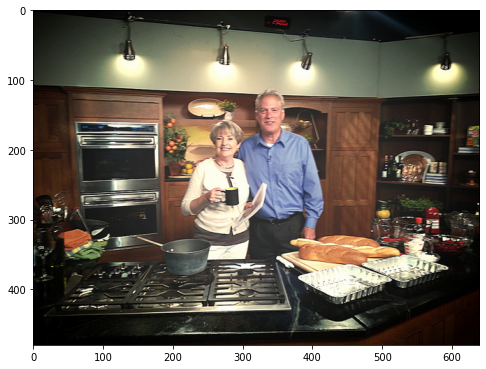

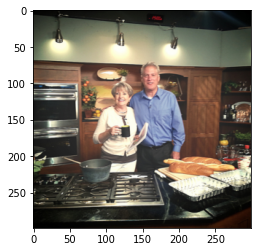

a woman standing in a kitchen preparing food . <END>


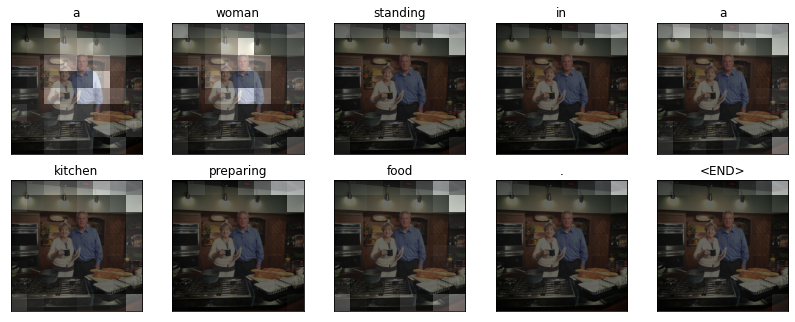

In [160]:
test_sample(coco_full_path(image_path_to_captions['test'][ds_index][0]),
            captioning_network, 
            captioning_network.rnn_decoder.get_device(), beam_width=128)